In [5]:
import findspark

findspark.find()
findspark.init()
import pyspark

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

In [7]:
%matplotlib inline

print (pyspark.__version__)

3.0.1


In [11]:
#Last we write the dataset as a CSV file, which despite being an awful format, is the one I encounter every day.
n_samples=10000
n_features=3
X, y = make_blobs(n_samples=n_samples, centers=10, n_features=n_features, random_state=42)

# add a row index as a string
pddf = pd.DataFrame(X, columns=['x', 'y', 'z'])
pddf['id'] = 'row'+pddf.index.astype(str)

#move it first (left)
cols = list(pddf)
cols.insert(0, cols.pop(cols.index('id')))
pddf = pddf.loc[:, cols]
pddf.head()

# save the ndarray as a csv file
pddf.to_csv('input.csv', index=False)

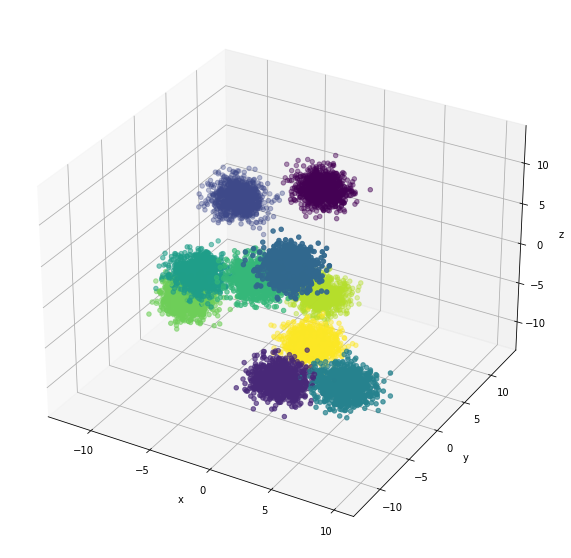

In [12]:
#This is a visualization of the data we just generated, where the true type of each data point is represented by a unique color.
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(X[:,0], X[:,1], X[:,2], c=y)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

In [14]:
#Spark SQL is a Spark module for structured data processing. Unlike the basic Spark RDD API, the interfaces provided by Spark SQL provide Spark with more information about the structure of both the data and the computation being performed.
sqlContext = SQLContext(pyspark.SparkContext(appName="K-means_Spark"))

In [15]:
FEATURES_COL = ['x', 'y', 'z']
path = 'input.csv'

In [16]:
df = sqlContext.read.csv(path, header=True) # requires spark 2.0
df.show()

+-----+--------------------+-------------------+-------------------+
|   id|                   x|                  y|                  z|
+-----+--------------------+-------------------+-------------------+
| row0|  -6.077699676970267|-2.9096103057273632|-1.5181728865169748|
| row1| -1.0122600489217026|  7.322841304183577| -5.442407430432608|
| row2|  -8.297006462627731| 6.3228935430154625|  1.167204760454971|
| row3|  -3.507121456057238|  4.784811751712145|  -5.44494747291675|
| row4|   -5.12282340491732| -3.322049741451506|-0.5069804719890176|
| row5|  -2.476400627641164|  8.255790793498251| 4.4094781220223345|
| row6|   7.315395347991067| -5.079448952098217| -7.291214948142356|
| row7|  -2.016746359044601|   9.30345477210614|  7.095178976138996|
| row8|-0.23381850372561575| -4.892681101883508| 2.1228876266871093|
| row9|   6.565442081261875| -6.855994160254796| -6.798321268724102|
|row10|  -5.690284570490115| -6.482740258743004|-0.9246966808128123|
|row11|-0.01798614270656...|  2.76

In [18]:
# Notice that the table header is included as the first row. We ignore that for now and convert data to a Spark dataframe.
print (df)
df.show()

DataFrame[id: string, x: string, y: string, z: string]
+-----+--------------------+-------------------+-------------------+
|   id|                   x|                  y|                  z|
+-----+--------------------+-------------------+-------------------+
| row0|  -6.077699676970267|-2.9096103057273632|-1.5181728865169748|
| row1| -1.0122600489217026|  7.322841304183577| -5.442407430432608|
| row2|  -8.297006462627731| 6.3228935430154625|  1.167204760454971|
| row3|  -3.507121456057238|  4.784811751712145|  -5.44494747291675|
| row4|   -5.12282340491732| -3.322049741451506|-0.5069804719890176|
| row5|  -2.476400627641164|  8.255790793498251| 4.4094781220223345|
| row6|   7.315395347991067| -5.079448952098217| -7.291214948142356|
| row7|  -2.016746359044601|   9.30345477210614|  7.095178976138996|
| row8|-0.23381850372561575| -4.892681101883508| 2.1228876266871093|
| row9|   6.565442081261875| -6.855994160254796| -6.798321268724102|
|row10|  -5.690284570490115| -6.482740258743004|

In [19]:
#Converting all data to float is possible in a single line. However this would make the 'id' column filled with null, or we would have to omit it:
df_feat = df.select(*(df[c].cast("float").alias(c) for c in df.columns[1:]))
df_feat.show()

+------------+----------+----------+
|           x|         y|         z|
+------------+----------+----------+
|  -6.0776997|-2.9096103|-1.5181729|
|  -1.0122601|  7.322841|-5.4424076|
|   -8.297007| 6.3228936| 1.1672047|
|  -3.5071216|  4.784812|-5.4449472|
|   -5.122823|-3.3220499|-0.5069805|
|  -2.4764006|  8.255791|  4.409478|
|   7.3153954| -5.079449| -7.291215|
|  -2.0167463|  9.303454|  7.095179|
|  -0.2338185| -4.892681| 2.1228876|
|    6.565442| -6.855994|-6.7983212|
|  -5.6902847|-6.4827404|-0.9246967|
|-0.017986143| 2.7632365| -8.814824|
|  -6.9042625|-6.1491723|-3.5354295|
|  -10.389865|  9.537853|  0.674591|
|   3.9688683|-6.0467844| -5.462389|
|   -7.337052|-3.7689247| -5.261122|
|   -8.991589|  8.738728|  3.864116|
| -0.18098584|  5.482743| -4.900118|
|   3.3193955|-6.3573766| -6.978025|
|  -2.0266335|-3.4171724|0.48218703|
+------------+----------+----------+
only showing top 20 rows



In [20]:
for col in df.columns:
    if col in FEATURES_COL:
        df = df.withColumn(col,df[col].cast('float'))
df.show()

+-----+------------+----------+----------+
|   id|           x|         y|         z|
+-----+------------+----------+----------+
| row0|  -6.0776997|-2.9096103|-1.5181729|
| row1|  -1.0122601|  7.322841|-5.4424076|
| row2|   -8.297007| 6.3228936| 1.1672047|
| row3|  -3.5071216|  4.784812|-5.4449472|
| row4|   -5.122823|-3.3220499|-0.5069805|
| row5|  -2.4764006|  8.255791|  4.409478|
| row6|   7.3153954| -5.079449| -7.291215|
| row7|  -2.0167463|  9.303454|  7.095179|
| row8|  -0.2338185| -4.892681| 2.1228876|
| row9|    6.565442| -6.855994|-6.7983212|
|row10|  -5.6902847|-6.4827404|-0.9246967|
|row11|-0.017986143| 2.7632365| -8.814824|
|row12|  -6.9042625|-6.1491723|-3.5354295|
|row13|  -10.389865|  9.537853|  0.674591|
|row14|   3.9688683|-6.0467844| -5.462389|
|row15|   -7.337052|-3.7689247| -5.261122|
|row16|   -8.991589|  8.738728|  3.864116|
|row17| -0.18098584|  5.482743| -4.900118|
|row18|   3.3193955|-6.3573766| -6.978025|
|row19|  -2.0266335|-3.4171724|0.48218703|
+-----+----

In [21]:
#Drop the null values
df = df.na.drop()
df.show()

+-----+------------+----------+----------+
|   id|           x|         y|         z|
+-----+------------+----------+----------+
| row0|  -6.0776997|-2.9096103|-1.5181729|
| row1|  -1.0122601|  7.322841|-5.4424076|
| row2|   -8.297007| 6.3228936| 1.1672047|
| row3|  -3.5071216|  4.784812|-5.4449472|
| row4|   -5.122823|-3.3220499|-0.5069805|
| row5|  -2.4764006|  8.255791|  4.409478|
| row6|   7.3153954| -5.079449| -7.291215|
| row7|  -2.0167463|  9.303454|  7.095179|
| row8|  -0.2338185| -4.892681| 2.1228876|
| row9|    6.565442| -6.855994|-6.7983212|
|row10|  -5.6902847|-6.4827404|-0.9246967|
|row11|-0.017986143| 2.7632365| -8.814824|
|row12|  -6.9042625|-6.1491723|-3.5354295|
|row13|  -10.389865|  9.537853|  0.674591|
|row14|   3.9688683|-6.0467844| -5.462389|
|row15|   -7.337052|-3.7689247| -5.261122|
|row16|   -8.991589|  8.738728|  3.864116|
|row17| -0.18098584|  5.482743| -4.900118|
|row18|   3.3193955|-6.3573766| -6.978025|
|row19|  -2.0266335|-3.4171724|0.48218703|
+-----+----

In [22]:
# Create a features column to be used in the clustering. 
# park's implementation of KMeans is a bit different from for example scikit-learn's version. 
# We need to store all features as an array of floats, and store this array as a column called "features". 
# Since we do no longer need the original columns we filter them out with a select statement.
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('id', 'features')
df_kmeans.show()


+-----+--------------------+
|   id|            features|
+-----+--------------------+
| row0|[-6.0776996612548...|
| row1|[-1.0122600793838...|
| row2|[-8.2970066070556...|
| row3|[-3.5071215629577...|
| row4|[-5.1228232383728...|
| row5|[-2.4764006137847...|
| row6|[7.31539535522460...|
| row7|[-2.0167462825775...|
| row8|[-0.2338185012340...|
| row9|[6.56544208526611...|
|row10|[-5.6902847290039...|
|row11|[-0.0179861430078...|
|row12|[-6.9042625427246...|
|row13|[-10.389864921569...|
|row14|[3.96886825561523...|
|row15|[-7.3370518684387...|
|row16|[-8.9915885925292...|
|row17|[-0.1809858381748...|
|row18|[3.31939554214477...|
|row19|[-2.0266335010528...|
+-----+--------------------+
only showing top 20 rows



In [25]:
# Train the machine learning model
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[-0.31260155  3.77092519 -7.55332038]
[ 4.11111715 -9.61155031  9.41405178]
[-6.40240706 -4.49908134 -2.19758025]
[-8.79877678  7.30752724  2.00242494]
[ 1.97796779 -6.9550201  -6.92516782]
[-2.46074836  9.0641161   4.6330292 ]
[-1.31238277 -4.21721709  2.23366874]
[-7.83720508 -3.93807833 -2.96203727]
[ 6.60272087 -5.69554976 -6.27949674]
[-6.33742787 -3.84764575  0.67755642]


In [26]:
# Their is one import thing left to do; assigning the individual rows to the nearest cluster centroid
transformed = model.transform(df_kmeans).select('id', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(id='row0', prediction=2), Row(id='row1', prediction=0), Row(id='row2', prediction=3)]


In [27]:
# From the rows returned by the collect method it is trivial to create a new dataframe using our SQL context.
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+-----+----------+
|   id|prediction|
+-----+----------+
| row0|         2|
| row1|         0|
| row2|         3|
| row3|         0|
| row4|         9|
| row5|         5|
| row6|         8|
| row7|         5|
| row8|         6|
| row9|         8|
|row10|         2|
|row11|         0|
|row12|         2|
|row13|         3|
|row14|         4|
|row15|         7|
|row16|         3|
|row17|         0|
|row18|         4|
|row19|         6|
+-----+----------+
only showing top 20 rows



In [28]:
# Join the prediction with the original data
df_pred = df_pred.join(df, 'id')
df_pred.show()

+-----+----------+------------+----------+----------+
|   id|prediction|           x|         y|         z|
+-----+----------+------------+----------+----------+
| row0|         2|  -6.0776997|-2.9096103|-1.5181729|
| row1|         0|  -1.0122601|  7.322841|-5.4424076|
| row2|         3|   -8.297007| 6.3228936| 1.1672047|
| row3|         0|  -3.5071216|  4.784812|-5.4449472|
| row4|         9|   -5.122823|-3.3220499|-0.5069805|
| row5|         5|  -2.4764006|  8.255791|  4.409478|
| row6|         8|   7.3153954| -5.079449| -7.291215|
| row7|         5|  -2.0167463|  9.303454|  7.095179|
| row8|         6|  -0.2338185| -4.892681| 2.1228876|
| row9|         8|    6.565442| -6.855994|-6.7983212|
|row10|         2|  -5.6902847|-6.4827404|-0.9246967|
|row11|         0|-0.017986143| 2.7632365| -8.814824|
|row12|         2|  -6.9042625|-6.1491723|-3.5354295|
|row13|         3|  -10.389865|  9.537853|  0.674591|
|row14|         4|   3.9688683|-6.0467844| -5.462389|
|row15|         7|   -7.3370

In [29]:
# Convert to Pandas dataframe
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,x,y,z
id,,,,
row0,2,-6.077700,-2.909610,-1.518173
row1,0,-1.012260,7.322841,-5.442408
row2,3,-8.297007,6.322894,1.167205
row3,0,-3.507122,4.784812,-5.444947
row4,9,-5.122823,-3.322050,-0.506980


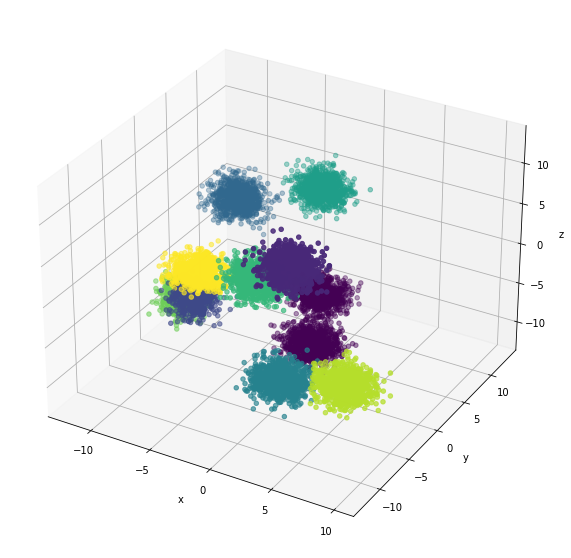

In [30]:
# Visualize the results
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.x, pddf_pred.y, pddf_pred.z, c=pddf_pred.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

In [ ]:
# now shut down the Spark context
sc.stop()